In [1]:
%%capture
!pip install -q -r /kaggle/input/rsna-breast-cancer-detection-github/RSNA-Breast-Cancer-Detection-main/requirements_sub.txt --no-index --find-links=/kaggle/input/rsna-pip-wheels
!pip install /kaggle/input/nvidia-dali-wheel/nvidia_dali_nightly_cuda110-1.22.0.dev20221213-6757685-py3-none-manylinux2014_x86_64.whl
!pip uninstall -y timm

In [2]:
%%capture
!pip install /kaggle/input/rsna-pip-wheels/timm-0.8.11.dev0-py3-none-any.whl

In [3]:
%%capture
!pip install -q dicomsdl --no-index --find-links=/kaggle/input/rsnabc-pip-wheel

In [4]:
import sys
GITHUB_PATH='/kaggle/input/rsna-breast-cancer-detection-github/RSNA-Breast-Cancer-Detection-main'
sys.path.append(f'{GITHUB_PATH}/configs')
sys.path.append(f'{GITHUB_PATH}/data')
sys.path.append(f'{GITHUB_PATH}/models')
sys.path.append(f'{GITHUB_PATH}/scripts')
sys.path.append(f'{GITHUB_PATH}/postprocess')

In [5]:
import timm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import sys
import importlib
from copy import copy
import gc
import shutil 
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

import multiprocessing as mp
# from tqdm import tqdm
import glob
from scipy.special import expit

import albumentations as A
import cv2
import dicomsdl

cv2.setNumThreads(0)

from os.path import join
from torch.cuda.amp import GradScaler, autocast

import pydicom
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali import pipeline_def
from nvidia.dali.types import DALIDataType
from pydicom.filebase import DicomBytesIO
from kernel_utils import feed_ndarray, to_torch_type, FilterImage, parse_window_element, linear_window
from PIL import Image

#timm.__version__, cv2.__version__

In [6]:
COMP_FOLDER = '/kaggle/input/rsna-breast-cancer-detection/'
DATA_FOLDER = COMP_FOLDER + 'test_images/'

sample_submission = pd.read_csv(COMP_FOLDER + 'sample_submission.csv')
sample_submission

,prediction_id,cancer
0,10008_L,0.021168
1,10008_R,0.021168


In [7]:
# Params

COMP_FOLDER = '/kaggle/input/rsna-breast-cancer-detection/'
DATA_FOLDER = COMP_FOLDER + 'test_images/'

sample_submission = pd.read_csv(COMP_FOLDER + 'sample_submission.csv')

PUBLIC_RUN = len(sample_submission) == 2

N_CORES = mp.cpu_count()
MIXED_PRECISION = False
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
FILTER_IMAGES = True

RAM_CHECK = False
OOF_CHECK = False
DEBUG = False

test_df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')
test_df['cancer'] = 0


if PUBLIC_RUN is False:
    RAM_CHECK = False
    OOF_CHECK = False
    DEBUG = False

if RAM_CHECK is True:
    #tbd
    pass
    
if OOF_CHECK is True:
    test_df = pd.read_csv('/kaggle/input/rsnabc-aws-data/train_folded_v01.csv')
    #patient_filter = list(sorted((set(test_df.patient_id.unique()))))[:100]
    #test_df = test_df[test_df.patient_id.isin(patient_filter)]
    test_df = test_df[test_df['fold']==0].copy()
    DATA_FOLDER = DATA_FOLDER.replace('test','train')

if DEBUG is True:
    # test_df = test_df.head(100)
    #tbd
    pass

test_df

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,cancer
0,2,10008,736471439,L,MLO,81,0,21,10008_L,0
1,2,10008,1591370361,L,CC,81,0,21,10008_L,0
2,2,10008,68070693,R,MLO,81,0,21,10008_R,0
3,2,10008,361203119,R,CC,81,0,21,10008_R,0


In [8]:
print(f'Len df : {len(test_df)}')

Len df : 4


In [9]:
test_df["fns"] = test_df['patient_id'].astype(str) + '/' + test_df['image_id'].astype(str) + '.dcm'

In [10]:
def convert_dicom_to_j2k(file, save_folder=""):
    patient = file.split('/')[-2]
    image = file.split('/')[-1][:-4]
    dcmfile = pydicom.dcmread(file)

    if dcmfile.file_meta.TransferSyntaxUID == '1.2.840.10008.1.2.4.90':
        with open(file, 'rb') as fp:
            raw = DicomBytesIO(fp.read())
            ds = pydicom.dcmread(raw)
        offset = ds.PixelData.find(b"\x00\x00\x00\x0C")  #<---- the jpeg2000 header info we're looking for
        hackedbitstream = bytearray()
        hackedbitstream.extend(ds.PixelData[offset:])
        with open(save_folder + f"{patient}_{image}.jp2", "wb") as binary_file:
            binary_file.write(hackedbitstream)

            
@pipeline_def
def j2k_decode_pipeline(j2kfiles):
    jpegs, _ = fn.readers.file(files=j2kfiles)
    images = fn.experimental.decoders.image(jpegs, device='mixed', output_type=types.ANY_DATA, dtype=DALIDataType.UINT16)
    return images

def process_dicom(img, dicom):
    try:
        invert = getattr(dicom, "PhotometricInterpretation", None) == "MONOCHROME1"
    except:
        invert = False
    try:
        voi_func = getattr(dicom, "VOILUTFunction", "LINEAR")
        if voi_func is None:
            voi_func = 'LINEAR'
        voi_func = voi_func.strip().upper()
    except:
        voi_func = 'LINEAR'

    center = parse_window_element(dicom["WindowCenter"])
    width = parse_window_element(dicom["WindowWidth"])
    if (voi_func in ["LINEAR","SIGMOID"]) & (center is not None) & (width is not None):
        img = linear_window(img, center, width)

    img = (img - img.min()) / (img.max() - img.min())
    if invert:
        img = 1 - img
    return img

In [11]:
SAVE_FOLDER = "/tmp/output/"
os.makedirs(SAVE_FOLDER, exist_ok=True)
N_CHUNKS = len(test_df["fns"]) // 2000 if len(test_df["fns"]) > 2000 else 1
CHUNKS = [(len(test_df["fns"]) / N_CHUNKS * k, len(test_df["fns"]) / N_CHUNKS * (k + 1)) for k in range(N_CHUNKS)]
CHUNKS = np.array(CHUNKS).astype(int)
J2K_FOLDER = "/tmp/j2k/"

In [12]:
if FILTER_IMAGES:
    filt = FilterImage(anchor_size = 1024, kernel_size = 13)
    filt.to('cuda')
    filt.kernel = filt.kernel.to('cuda')
    rle_x_dict = {}
    rle_y_dict = {}

In [13]:
class cfg:
    image_width = 1024
    image_height = 1024
    
val_aug = A.Compose([
    A.CenterCrop(width=cfg.image_width, height=cfg.image_height, p=1.0)
])

def pad_sides(img, padsize):
    paddim = int(img.shape[0] > img.shape[1])
    if paddim == 1:
        padimg = np.zeros((img.shape[0], padsize//2), dtype = np.uint8)
    else:
        padimg = np.zeros((padsize//2, img.shape[1]), dtype = np.uint8)
    img = np.concatenate((padimg, img, padimg), paddim)
    return img

def resize_image(img, x_idx, y_idx, cfg = cfg):
    # x_idx = filt.rldecode(*rle_x_dict[f.split('/')[-1]])
    # y_idx = filt.rldecode(*rle_y_dict[f.split('/')[-1]])
    
    img = img[y_idx>0][:, x_idx>0]
    image_width=cfg.image_width
    image_height = cfg.image_height
    
    if max(img.shape) < image_width:
        #img = img[:, :, 0]
        hh, ww = img.shape
        scale = image_width * 1.125 / max(hh, ww)
        new_hh, new_ww = int(round(hh * scale)), int(round(ww * scale))
        img = Image.fromarray(img).resize((new_ww, new_hh), Image.Resampling.LANCZOS)
        img = np.array(img)
        img = img[:, :, np.newaxis]
        
    # Pad, augment and resize large image
    #img = img[:, :, 0]
    padsize = abs(img.shape[0] - img.shape[1])
    if padsize > 2:
        img = pad_sides(img, padsize//5)
        
    img = Image.fromarray(img)
    assert image_width == image_height
    new_size = int(image_width * 1.125)
    img.thumbnail((new_size, new_size), Image.Resampling.LANCZOS)
    img = np.array(img)
    
    padsize = abs(img.shape[0] - img.shape[1])
    if padsize > 2:
        img = pad_sides(img, padsize)
        
    img = img[:,:,np.newaxis]
    img = val_aug(image=img)["image"]
            
    return img

In [14]:
for ttt, chunk in enumerate(tqdm(CHUNKS)):
    print(f'chunk {ttt} of {len(CHUNKS)} chunks')
    os.makedirs(J2K_FOLDER, exist_ok=True)

    _ = Parallel(n_jobs=2)(
        delayed(convert_dicom_to_j2k)(f'{DATA_FOLDER}/{img}', save_folder=J2K_FOLDER)
        for img in test_df["fns"].tolist()[chunk[0]: chunk[1]]
    )
    
    j2kfiles = glob.glob(J2K_FOLDER + "*.jp2")

    if not len(j2kfiles):
        continue

    pipe = j2k_decode_pipeline(j2kfiles, batch_size=1, num_threads=2, device_id=0, debug=True)
    pipe.build()

    for i, f in enumerate(tqdm(j2kfiles)):
        patient, image = f.split('/')[-1][:-4].split('_')
        dicom = pydicom.dcmread(DATA_FOLDER + f"/{patient}/{image}.dcm")

        out = pipe.run()

        # Dali -> Torch
        img = out[0][0]
        img_torch = torch.empty(img.shape(), dtype=torch.int16, device="cuda")
        feed_ndarray(img, img_torch, cuda_stream=torch.cuda.current_stream(device=0))
        img = img_torch.float()
        img = process_dicom(img, dicom)

        img = (img * 255).clip(0,255).to(torch.uint8)
        
        # f"{row.patient_id}_{row.laterality}_{row['view']}_{row.image_id}.png"
        out_file_name = SAVE_FOLDER + f"{patient}_{image}.png"
        if FILTER_IMAGES:
            dkey = out_file_name.split('/')[-1]
            x_idx, y_idx = filt(img[:,:,0], RLE = True)
        x_idx = filt.rldecode(*x_idx)
        y_idx = filt.rldecode(*y_idx)
        # Back to CPU, filter resize + SAVE
        img = img.cpu().numpy()
        img = resize_image(img[:,:,0], x_idx, y_idx, cfg = cfg)

        cv2.imwrite(out_file_name, img)

    shutil.rmtree(J2K_FOLDER)
print(f'DALI Raw image load complete')

  0%|          | 0/1 [00:00<?, ?it/s]

chunk 0 of 1 chunks


  0%|          | 0/4 [00:00<?, ?it/s]

DALI Raw image load complete


In [15]:
n_saved = len(glob.glob(f'{SAVE_FOLDER}/*.png'))
print(f'Image on disk count : {n_saved}')

Image on disk count : 4


In [16]:
import dicomsdl

def process(f, save_folder=""):
    patient = f.split('/')[-2]
    image = f.split('/')[-1][:-4]

    dicom = pydicom.dcmread(f)
    

    if dicom.file_meta.TransferSyntaxUID == '1.2.840.10008.1.2.4.90':  # ALREADY PROCESSED
        return
    
    dicom = dicomsdl.open(f)
    img = dicom.pixelData()
    img = process_dicom(img, dicom)
    img = (img * 255).clip(0,255).astype(np.uint8)
    
    img = torch.from_numpy(img).cuda()
    x_idx, y_idx = filt(img[:,:], RLE = True)
    x_idx = filt.rldecode(*x_idx)
    y_idx = filt.rldecode(*y_idx)
    # Back to CPU, filter resize + SAVE
    img = img.cpu().numpy()
    img = resize_image(img, x_idx, y_idx, cfg = cfg)    

    out_file_name = save_folder + f"{patient}_{image}.png"
    cv2.imwrite(out_file_name, img)
    return out_file_name

In [17]:
cpu_processed_filenames = Parallel(n_jobs=2)(
    delayed(process)(f'{DATA_FOLDER}/{img}', save_folder=SAVE_FOLDER)
    for img in tqdm(test_df["fns"])
)
cpu_processed_filenames = [f for f in cpu_processed_filenames if f]
print(f'CPU Raw image load complete with {len(cpu_processed_filenames)} loaded')

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU Raw image load complete with 0 loaded


In [18]:
gc.collect()
torch.cuda.empty_cache()

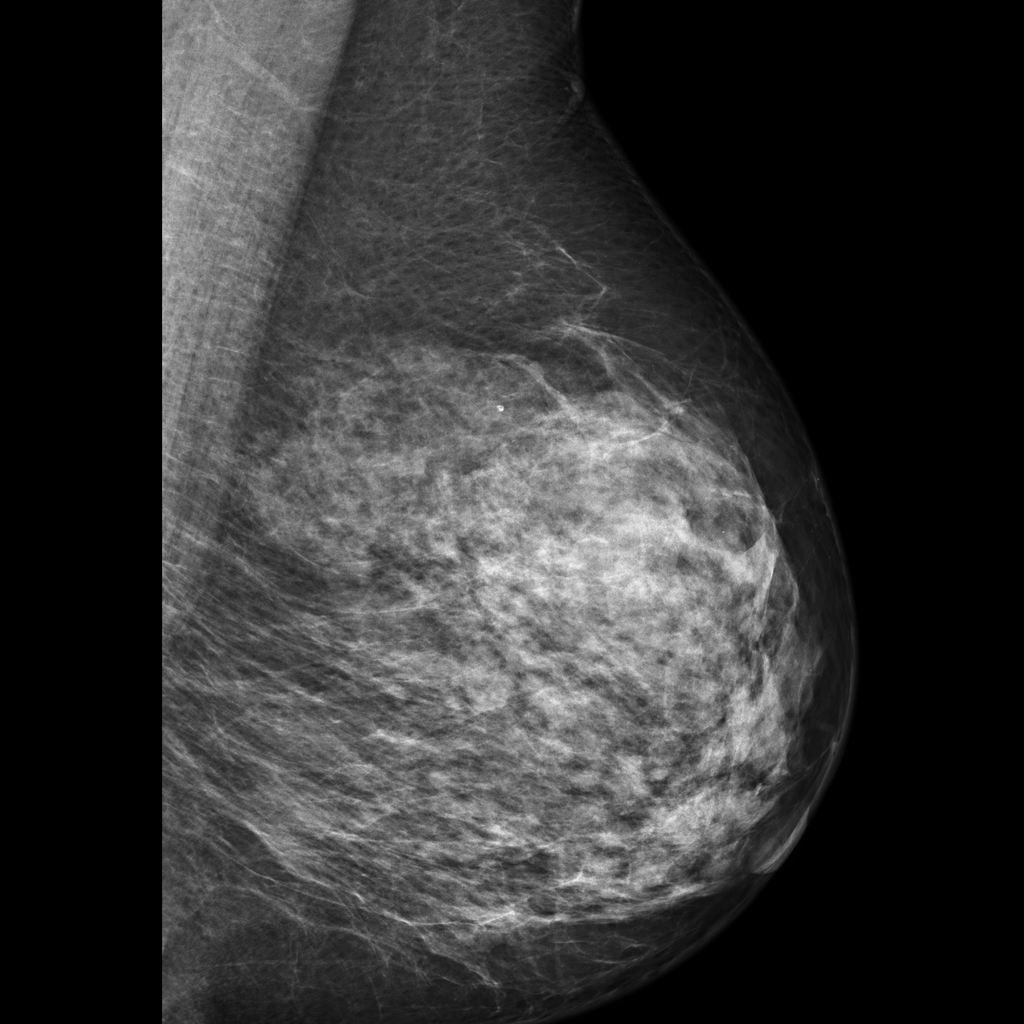

In [19]:
for tt,f in enumerate(glob.glob(f'{SAVE_FOLDER}/*.png')):
    img = cv2.imread(f, cv2.IMREAD_UNCHANGED)
    if tt == 1: break
Image.fromarray(img[:, :])

In [20]:
n_saved = len(glob.glob(f'{SAVE_FOLDER}/*.png'))
print(f'Image on disk count : {n_saved}')

Image on disk count : 4


In [21]:
for fn in glob.glob(f'{SAVE_FOLDER}/*.png')[:5]:
    print(cv2.imread(fn).shape)

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)


In [22]:
assert n_saved == len(test_df)

In [23]:
def get_cfg(CFG):
    cfg = importlib.import_module('default_config')
    importlib.reload(cfg)
    cfg = importlib.import_module(CFG)
    importlib.reload(cfg)
    cfg = copy(cfg.cfg)
    cfg.post_process_pipeline = importlib.import_module(cfg.post_process_pipeline).post_process_pipeline

    cfg.data_dir = COMP_FOLDER
    cfg.test_data_folder = DATA_FOLDER
    cfg.mixed_precision = MIXED_PRECISION
    cfg.pretrained = False
    cfg.pretrained_weights = False
    # cfg.batch_size = cfg.batch_size//3
    cfg.offline_inference = True
    cfg.device = DEVICE

    print(CFG, cfg.model, cfg.dataset, cfg.backbone, cfg.pretrained_weights, cfg.post_process_pipeline)
    
    return cfg

def get_state_dict(sd_fp):
    sd = torch.load(sd_fp, map_location="cpu")['model']
    sd = {k.replace("module.", ""):v for k,v in sd.items()}
    return sd

def get_nets(cfg,state_dicts):
    model = importlib.import_module(cfg.model)
    importlib.reload(model)
    Net = model.Net

    nets = []

    for i,state_dict in enumerate(state_dicts):
        net = Net(cfg).eval().to(DEVICE)
        print("loading dict")
        sd = get_state_dict(state_dict)
        net.load_state_dict(sd, strict=True)
        nets += [net]
        del sd
        gc.collect()
    return nets

def get_dl(test_df, cfg):
    ds = importlib.import_module(cfg.dataset)
    importlib.reload(ds)

    CustomDataset = ds.CustomDataset
    batch_to_device = ds.batch_to_device

    test_ds = CustomDataset(test_df, cfg, cfg.val_aug, mode="test")
    test_dl = DataLoader(test_ds, shuffle=False, batch_size=cfg.batch_size, collate_fn=ds.val_collate_fn, num_workers=N_CORES, pin_memory=True)

    return test_dl, batch_to_device

In [24]:
from torch.utils.data import Dataset, DataLoader

In [25]:
CFG = 'cfg_dh_4c_aux14B_b3_agg1'
state_dicts = sorted(glob.glob(f'/kaggle/input/breast-cancer-weights/cfg_dh_4c_aux14B_b3_agg1/fold-1/check*.pth'))
print(state_dicts)
cfg = get_cfg(CFG)
cfg.pretrained = False
cfg.batch_size = 2
cfg.val_batch_size = 2
cfg.data_folder = cfg.test_data_folder = SAVE_FOLDER
nets = get_nets(cfg,state_dicts)

['/kaggle/input/breast-cancer-weights/cfg_dh_4c_aux14B_b3_agg1/fold-1/checkpoint_last_seed260406.pth', '/kaggle/input/breast-cancer-weights/cfg_dh_4c_aux14B_b3_agg1/fold-1/checkpoint_last_seed880672.pth']
cfg_dh_4c_aux14B_b3_agg1 mdl_dh_4k_agg2 ds_dh_4j_aux8_agg1 tf_efficientnet_b3.ns_jft_in1k False <function post_process_pipeline at 0x79bed003a710>
loading dict
loading dict


In [26]:
for CFG1 in 'cfg_dh_4c_aux14B_v2_s_agg1 cfg_dh_4c_aux14B_b4_agg1 cfg_dh_4c_aux14B_b5_agg1'.split(): # cfg_ip_4c_aux14B_v2_m_agg1 
    state_dicts = sorted(glob.glob(f'/kaggle/input/breast-cancer-weights/{CFG1}/fold-1/check*.pth'))
    print(state_dicts)
    cfg1 = get_cfg(CFG1)
    nets += get_nets(cfg1,state_dicts)
    del CFG1, cfg1, state_dicts
print(f'Models loaded : {len(nets)}')

['/kaggle/input/breast-cancer-weights/cfg_dh_4c_aux14B_v2_s_agg1/fold-1/checkpoint_last_seed377219.pth', '/kaggle/input/breast-cancer-weights/cfg_dh_4c_aux14B_v2_s_agg1/fold-1/checkpoint_last_seed855889.pth']
cfg_dh_4c_aux14B_v2_s_agg1 mdl_dh_4k_agg2 ds_dh_4j_aux8_agg1 tf_efficientnetv2_s.in1k False <function post_process_pipeline at 0x79bed003a710>
loading dict
loading dict
['/kaggle/input/breast-cancer-weights/cfg_dh_4c_aux14B_b4_agg1/fold-1/checkpoint_last_seed366609.pth', '/kaggle/input/breast-cancer-weights/cfg_dh_4c_aux14B_b4_agg1/fold-1/checkpoint_last_seed564127.pth']
cfg_dh_4c_aux14B_b4_agg1 mdl_dh_4k_agg2 ds_dh_4j_aux8_agg1 tf_efficientnet_b4.ns_jft_in1k False <function post_process_pipeline at 0x79bed003a710>
loading dict
loading dict
['/kaggle/input/breast-cancer-weights/cfg_dh_4c_aux14B_b5_agg1/fold-1/checkpoint_last_seed163305.pth', '/kaggle/input/breast-cancer-weights/cfg_dh_4c_aux14B_b5_agg1/fold-1/checkpoint_last_seed415822.pth']
cfg_dh_4c_aux14B_b5_agg1 mdl_dh_4k_agg2

In [27]:
# sub_ds = CustomDataset(test_df, cfg, cfg.val_aug, mode="test")
# sub_dl = DataLoader(sub_ds, shuffle=False, batch_size=cfg.batch_size, collate_fn=val_collate_fn, num_workers=N_CORES, pin_memory=True)
test_df['biopsy']=0
test_df['density']='C'
test_df['BIRADS']=0.
test_df['invasive']=0
test_df['difficult_negative_case']=0
sub_dl, batch_to_device = get_dl(test_df, cfg)
#sub_dl.dataset.fns = [i.split('_')[0] + '_' + i.split('_')[-1]  for i in sub_dl.dataset.fns]
sub_dl.dataset.df.fns = sub_dl.dataset.df.fns.apply(lambda x: [i.split('_')[0] + '_' + i.split('_')[-1]  for i in x])


In [28]:
print(f'Dataloader length : {len(sub_dl.dataset)}')

Dataloader length : 2


In [29]:
results = []
with torch.inference_mode():
    preds = [[] for i in range(len(nets))]
    for tt, batch in tqdm(enumerate(sub_dl), total = len(sub_dl)):
        batch = batch_to_device(batch, cfg.device)
        for i, net in enumerate(nets):
            logits = net(batch)['logits'].sigmoid().float().detach().cpu().numpy()
            preds[i] += [logits]
        if tt%50==0: 
            print(f'processed {tt} batches from {len(sub_dl)}')
            gc.collect()
            torch.cuda.empty_cache()

    results += [preds]
    print('Prediction complete')

  0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


processed 0 batches from 1
Prediction complete


In [30]:
r2 = [np.array([np.concatenate(p, axis=0) for p in preds]) for preds in results]
preds = np.concatenate(r2, axis=1)
preds.shape #models images classes

(8, 2, 1)

In [31]:
# preds = np.array([np.concatenate(p, axis=0) for p in preds])
preds = preds.mean(0) #aggregate models
preds = preds[:,0]
preds.shape

(2,)

In [32]:
preds[:20]

array([9.6026204e-05, 2.3828904e-04], dtype=float32)

In [33]:
patient_id = sub_dl.dataset.df['patient_id'].values
laterality = sub_dl.dataset.df['laterality'].values

prediction_id = [f'{i}_{j}' for i,j in  zip(patient_id, laterality)]

pred_df = pd.DataFrame({'prediction_id': prediction_id, 'cancer': preds})
pred_df.shape

(2, 2)

In [34]:
pred_df

,prediction_id,cancer
0,10008_L,0.000096
1,10008_R,0.000238


In [35]:
#aggregate by prediction_id , i.e. by patient_laterality
sub = pred_df.groupby('prediction_id')[['cancer']].agg('mean')

#actual pp part
sub['cancer'] = (sub['cancer'].values > 0.32).astype(int)
sub

,cancer
prediction_id,
10008_L,0
10008_R,0


In [36]:
sub.to_csv('submission.csv')

In [37]:
if OOF_CHECK:
    
    def pfbeta(labels, predictions, beta):
        #official implementation
        y_true_count = 0
        ctp = 0
        cfp = 0

        for idx in range(len(labels)):
            prediction = min(max(predictions[idx], 0), 1)
            if (labels[idx]):
                y_true_count += 1
                ctp += prediction
    #             cfp += 1 - prediction #bugfix
            else:
                cfp += prediction

        beta_squared = beta * beta
        c_precision = ctp / (ctp + cfp)
        c_recall = ctp / y_true_count
        if (c_precision > 0 and c_recall > 0):
            result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
            return result
        else:
            return 0
    
    #aggregate by prediction_id , i.e. by patient_laterality
    test_df['prediction_id'] = test_df.apply(lambda x: f'{x.patient_id}_{x.laterality}', 1)
    test_df = test_df.groupby('prediction_id')[['cancer']].agg('mean')
    
    # Sort both the same
    test_df = test_df.loc[sub.index]

    y = test_df['cancer'].values#.astype(np.float32)
    y_pred = sub['cancer'].values
    
#     print(y.shape, y_pred.shape)
    
    score = pfbeta(y, y_pred, 1)
    print(score)